In [1]:
import NBHD
import dataset_utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import openpyxl

from pytorch_metric_learning import distances, losses, miners, reducers

def get_Cosine_margin(model, x_test, y_test=None):
    def cosine_distance(a, b):
        return 1 - torch.cosine_similarity(a[:, np.newaxis, :], b, dim=-1)
    
    # Compute test samples' Hamming distance
    class_hvs = model.class_hvs.data
    test_enc_hvs = model.encoding(x_test)
    test_Cosine_dist = cosine_distance(test_enc_hvs, class_hvs)

    sorted_test_Cosine_distance, _ = torch.sort(test_Cosine_dist, dim=-1, descending=False)
    test_enc_hvs_Cosine_margin = (sorted_test_Cosine_distance[:,1:]-sorted_test_Cosine_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
    mean_test_Cosine_margin = torch.mean(test_enc_hvs_Cosine_margin).item()

    return mean_test_Cosine_margin


def HD_test(model, x_test, y_test):
    out = model(x_test, embedding=False)
    preds = torch.argmax(out, dim=-1)

    acc = torch.mean((preds==y_test).float())	
    return acc


def test_combination(dataset, dim, levels, combinations, test_epochs = 10, HD_lr = 1.0, quant_lr=1.0, t=0.7, metric_lr = 0.001, enc_type='RP', similarity_type = "cosine", device = "cuda"):
    accuracies = []
    margins = []

    nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset(dataset, 256, "cuda")

    model = NBHD.HDC(dim = nFeatures, D=dim, num_classes=nClasses,levels=levels, enc_type=enc_type, similarity_type= similarity_type)
    model.init_quantize(x_train)

    initialized = False

    for combination in combinations:
        if combination == "HD":
            if not initialized:
                model.init_class(x_train, y_train)
                accuracies.append(HD_test(model, x_test, y_test).item())
                margins.append(get_Cosine_margin(model, x_test, y_test))
                initialized = True

            for epoch_i in range(1, test_epochs+1):
                model.HD_train_step(x_train, y_train, lr=HD_lr)
                accuracies.append(HD_test(model, x_test, y_test).item())
                margins.append(get_Cosine_margin(model, x_test, y_test))


        elif combination == "Metric":
            optimizer = optim.Adam(model.parameters(), lr=metric_lr)
            distance = distances.CosineSimilarity()

            reducer = reducers.ThresholdReducer(low=0.0)
            loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
            mining_func = miners.TripletMarginMiner(
                margin=0.2, distance=distance, type_of_triplets="semihard", )

            ### pytorch-metric-learning stuff ###
            for epoch_i in range(1, test_epochs + 1):
                NBHD.metric_train(model, loss_func, mining_func, device, train_loader, optimizer, epoch_i)
                if initialized:
                    accuracies.append(HD_test(model, x_test, y_test).item())
                    margins.append(get_Cosine_margin(model, x_test, y_test))
        
        
        elif combination == "Quant":
            if not initialized:
                model.init_class(x_train, y_train)
                accuracies.append(HD_test(model, x_test, y_test).item())
                margins.append(get_Cosine_margin(model, x_test, y_test))
                initialized = True

            optimizer = optim.SGD(model.parameters() , quant_lr)

            def cosineLoss(embeddings, labels, t=t):
                similarities = model.similarity(model.class_hvs, embeddings)
                a = (1 - similarities[torch.arange(similarities.size(0)), labels]).abs().mean() #

                similarities[torch.arange(similarities.size(0)), labels] = 0
                b = similarities.abs().mean() 
                return t * a + (1-t) * b

            quant_loss = cosineLoss
            for epoch_i in range(1, test_epochs + 1):
                NBHD.quant_train(model, quant_loss, device, train_loader, optimizer, epoch_i)
                accuracies.append(HD_test(model, x_test, y_test).item())
                margins.append(get_Cosine_margin(model, x_test, y_test))

    
    if not initialized:
        model.init_class(x_train, y_train)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))
        initialized = True

    plt.plot(accuracies, label="Accuracy", c = "blue")
    plt.plot(margins, label="Margins", c="cyan")
    plt.xlabel("iterations")
    plt.axvline(x=10, c= "red" , ls="--")
    plt.title("Accuracy of {} Levels, {} Dimensions, Dataset:{}, Combination: {}".format(levels, dim, dataset, combinations))
    plt.legend()
    plt.show()

    return accuracies, margins

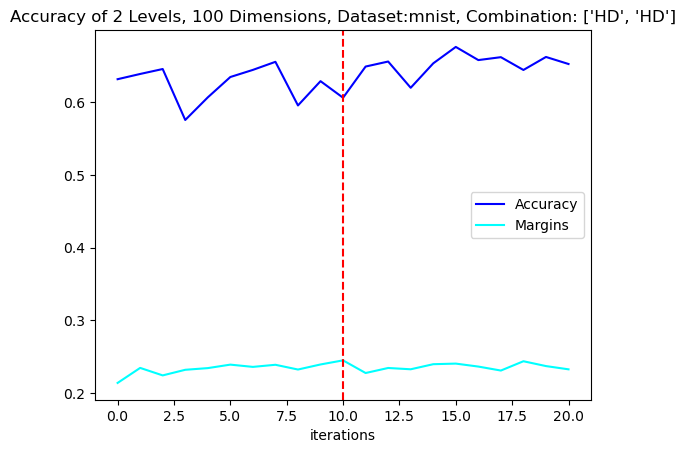

Final Acc: 0.6527999639511108  Final Margin: 0.23278534412384033


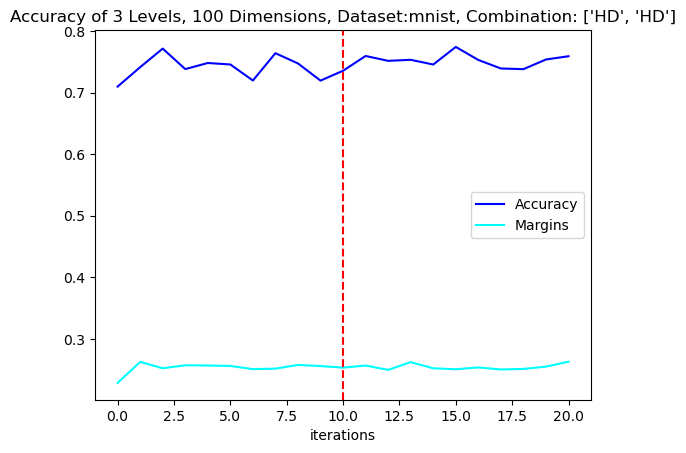

Final Acc: 0.7590000033378601  Final Margin: 0.26300927996635437


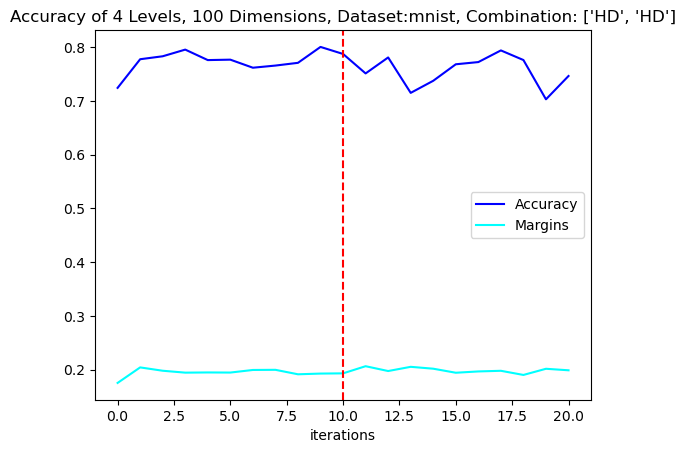

Final Acc: 0.7462999820709229  Final Margin: 0.19869069755077362


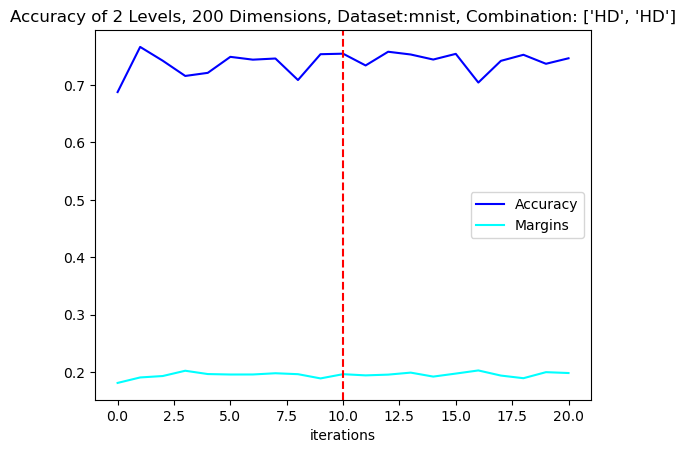

Final Acc: 0.7468000054359436  Final Margin: 0.19809889793395996


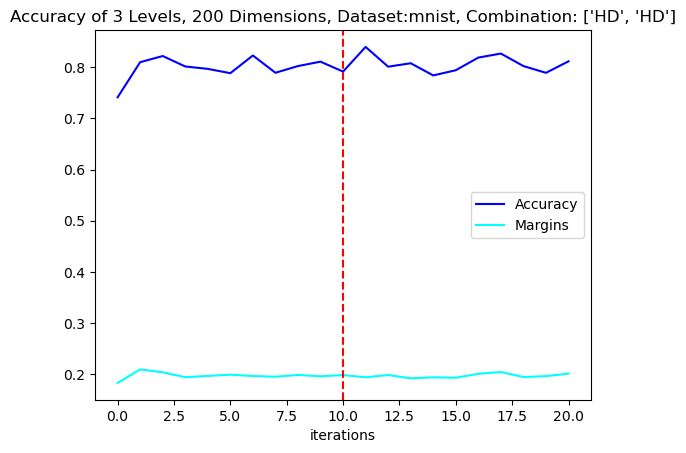

Final Acc: 0.8114999532699585  Final Margin: 0.20127476751804352


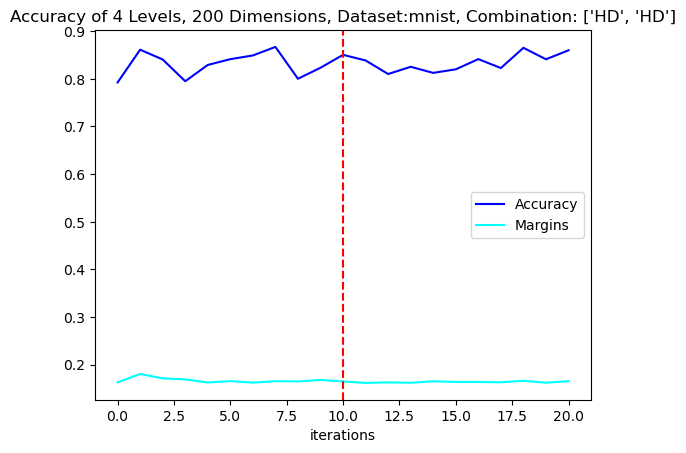

Final Acc: 0.8598999977111816  Final Margin: 0.16562113165855408


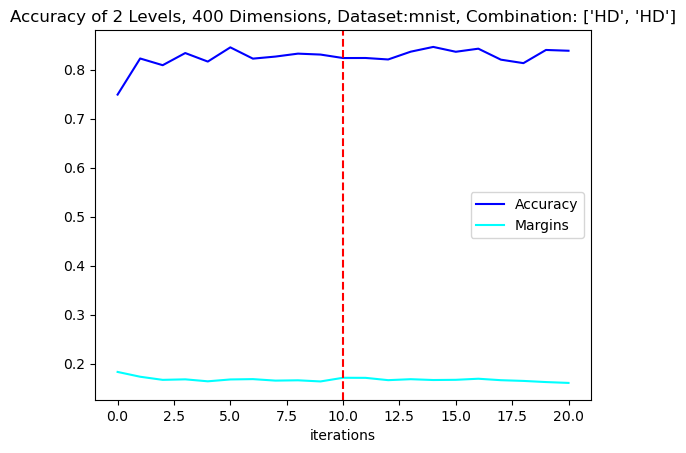

Final Acc: 0.8387999534606934  Final Margin: 0.16085022687911987


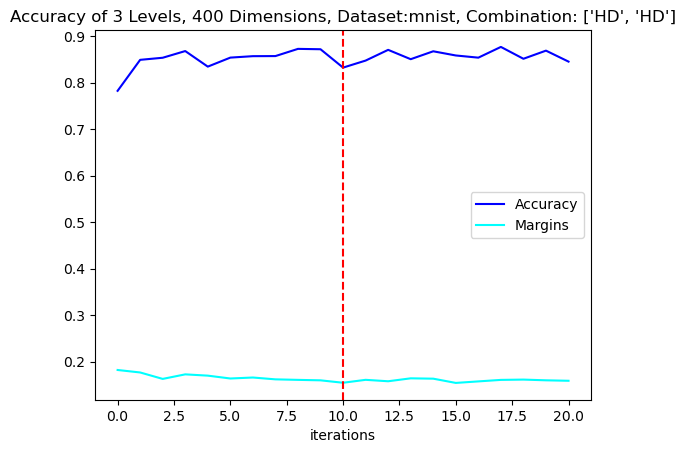

Final Acc: 0.8453999757766724  Final Margin: 0.15858685970306396


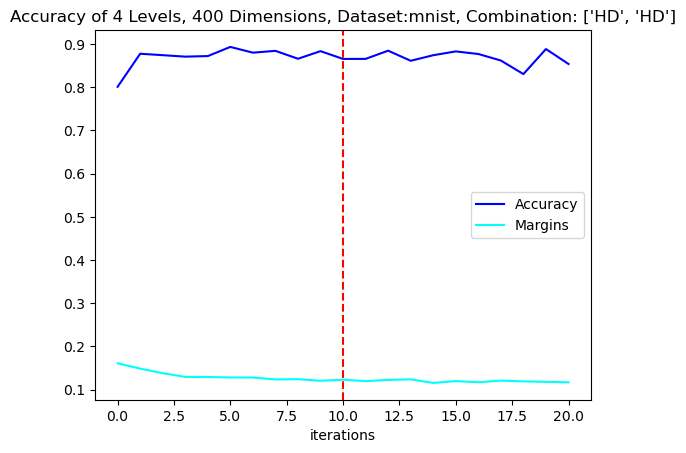

Final Acc: 0.8538999557495117  Final Margin: 0.11682161688804626


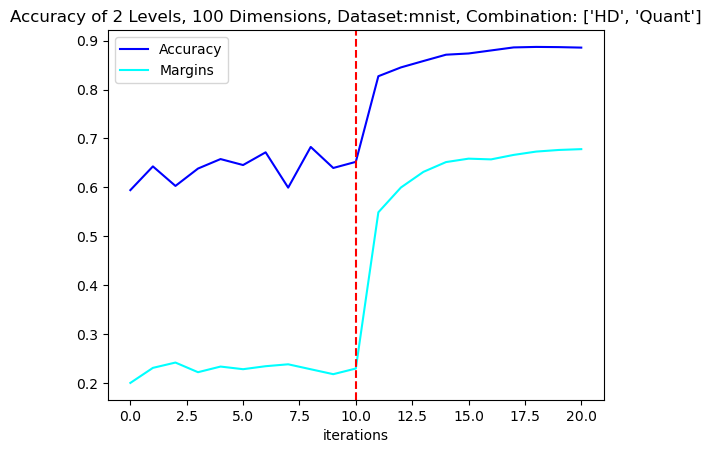

Final Acc: 0.8858000040054321  Final Margin: 0.6782048940658569


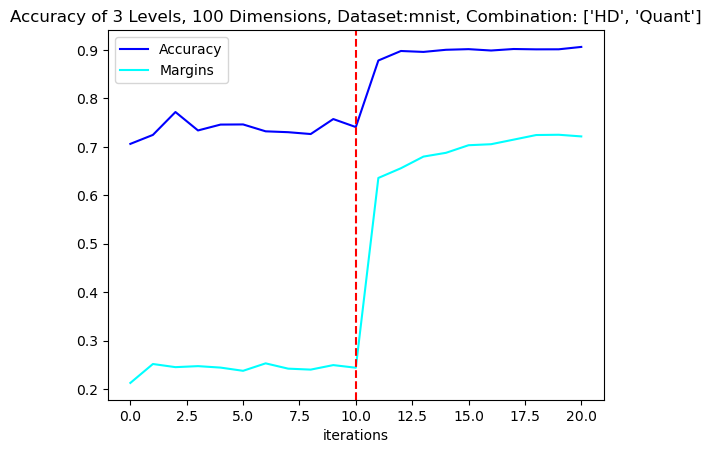

Final Acc: 0.9060999751091003  Final Margin: 0.7214956283569336


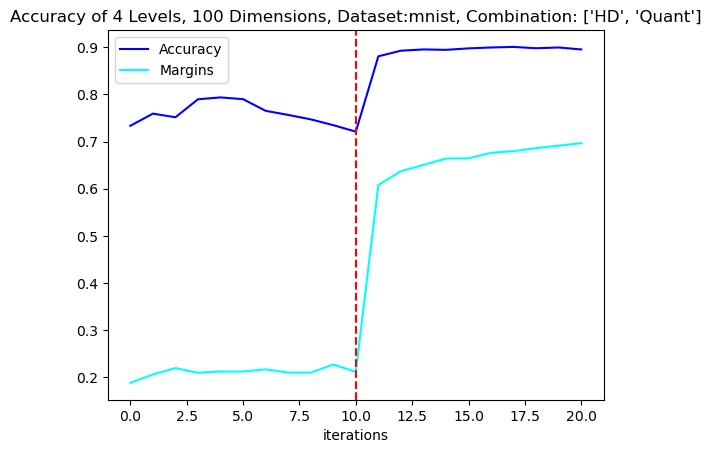

Final Acc: 0.8951999545097351  Final Margin: 0.6965801119804382


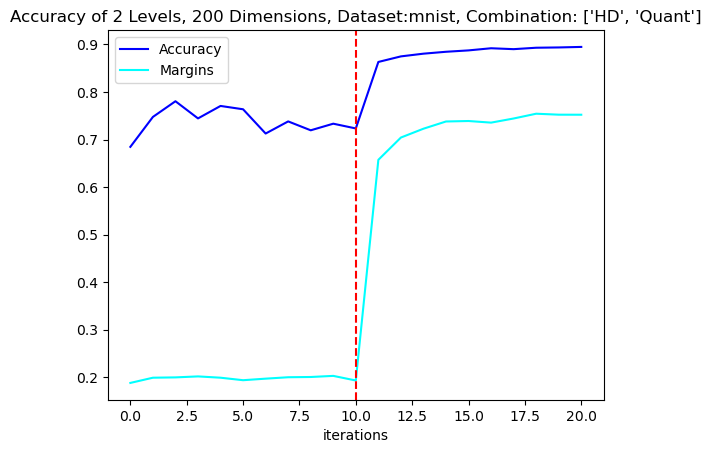

Final Acc: 0.8946999907493591  Final Margin: 0.7521581649780273


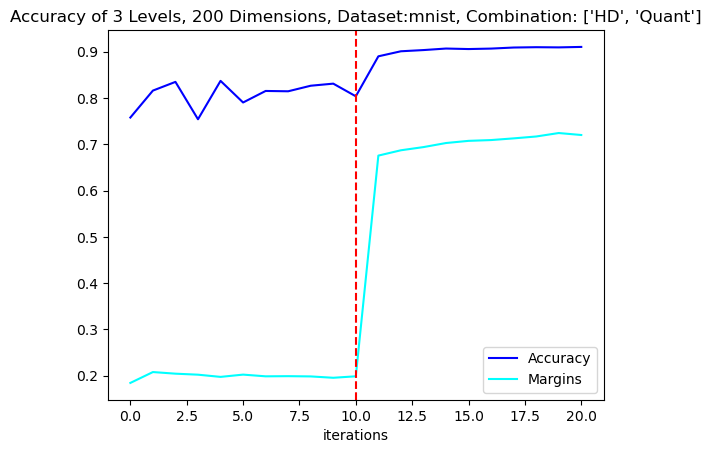

Final Acc: 0.9101999998092651  Final Margin: 0.7199913859367371


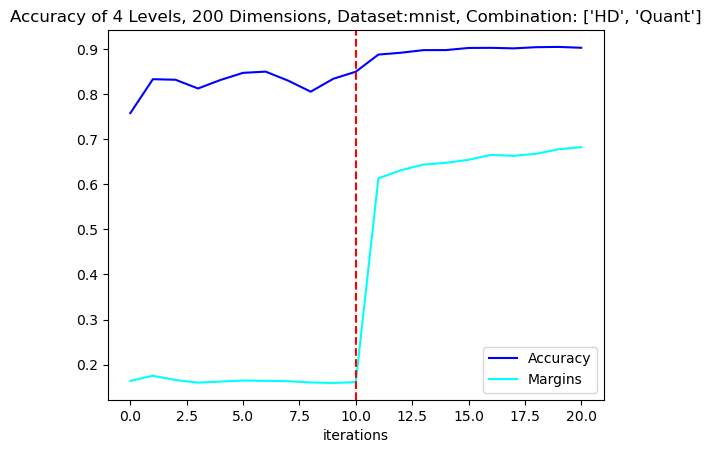

Final Acc: 0.9027999639511108  Final Margin: 0.6822361350059509


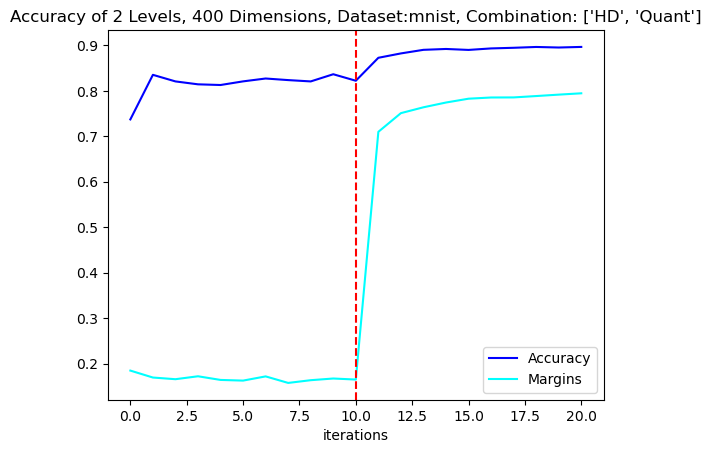

Final Acc: 0.8965999484062195  Final Margin: 0.7945513725280762


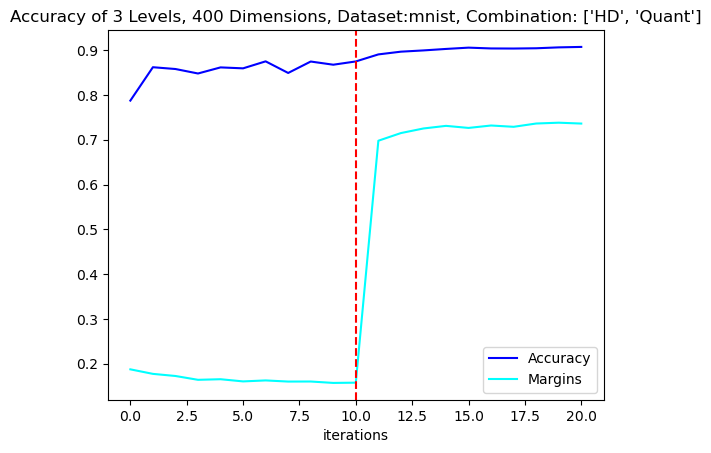

Final Acc: 0.9070999622344971  Final Margin: 0.7360628843307495


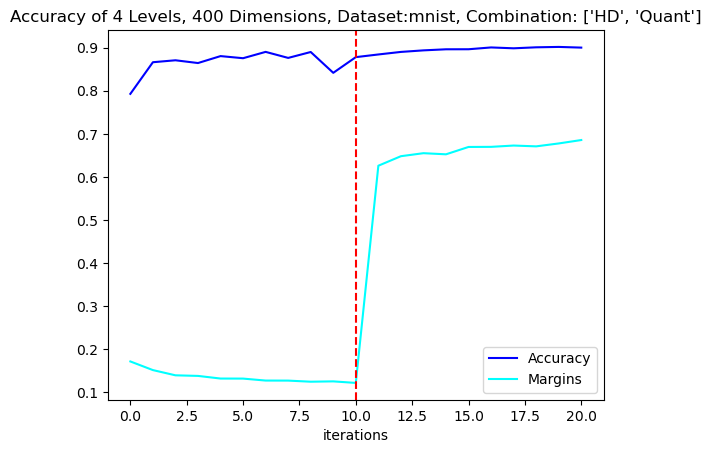

Final Acc: 0.9000999927520752  Final Margin: 0.685644268989563


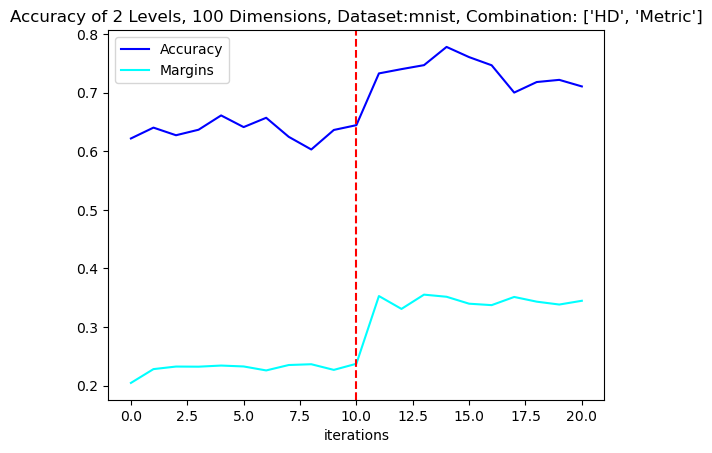

Final Acc: 0.710599958896637  Final Margin: 0.34484755992889404


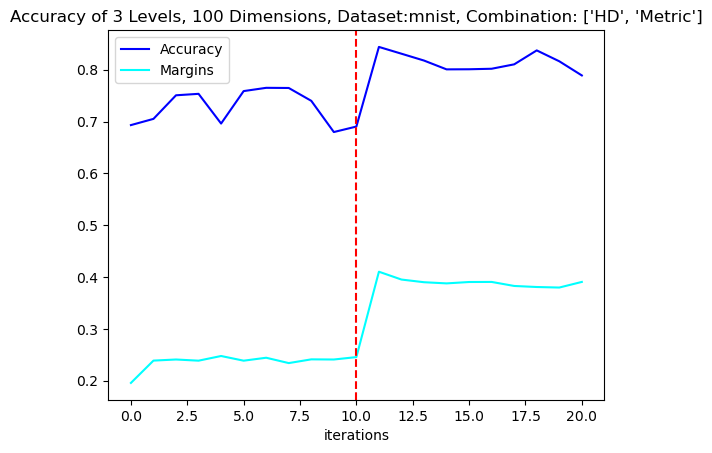

Final Acc: 0.7889999747276306  Final Margin: 0.3906830847263336


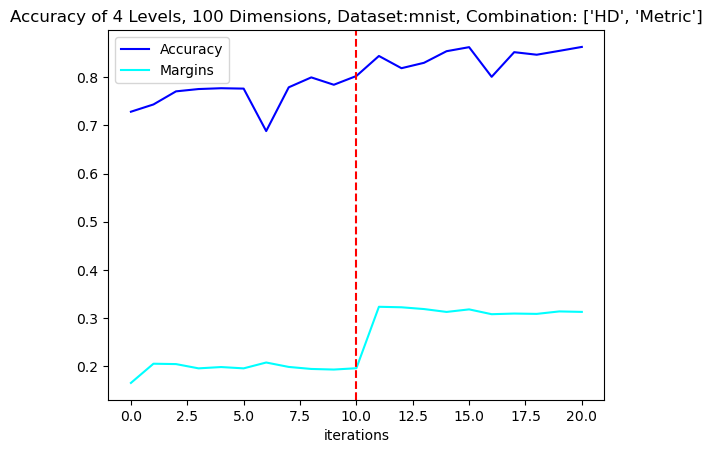

Final Acc: 0.8629999756813049  Final Margin: 0.3125845789909363


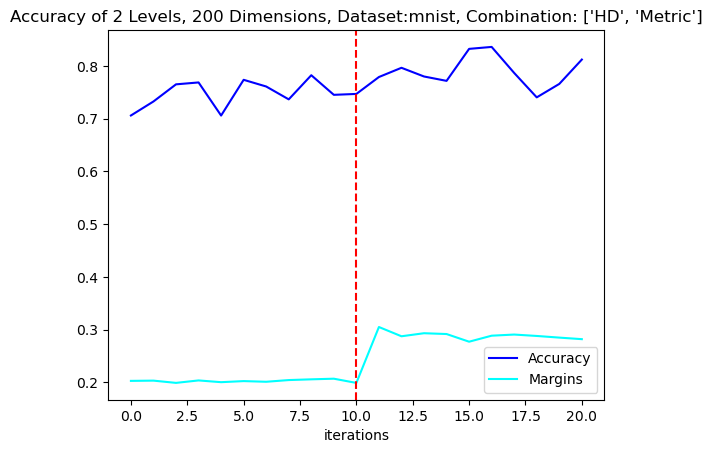

Final Acc: 0.8121999502182007  Final Margin: 0.28172311186790466


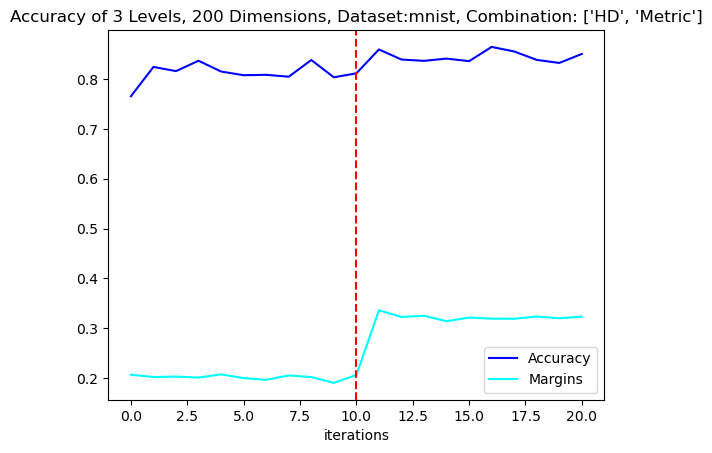

Final Acc: 0.8499999642372131  Final Margin: 0.32354065775871277


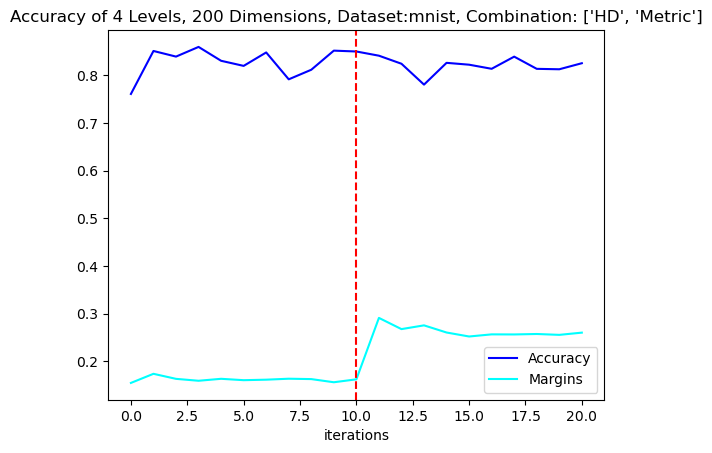

Final Acc: 0.825499951839447  Final Margin: 0.2601356506347656


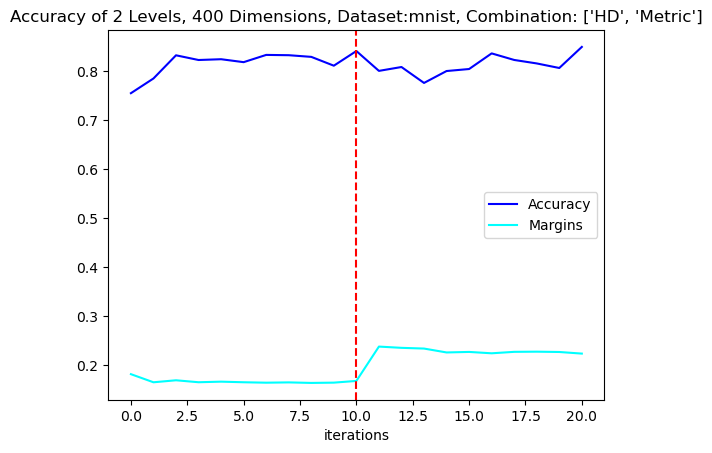

Final Acc: 0.8491999506950378  Final Margin: 0.2233821302652359


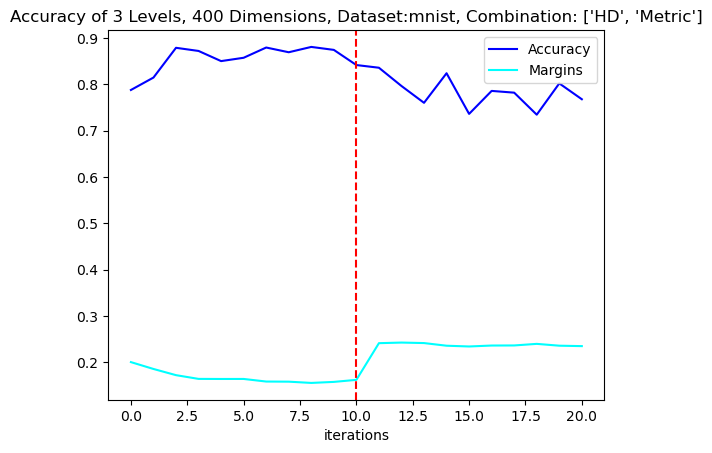

Final Acc: 0.7674999833106995  Final Margin: 0.2348136156797409


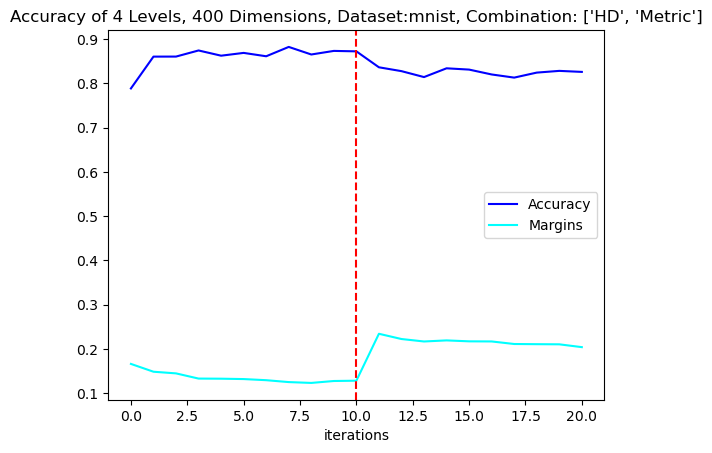

Final Acc: 0.8258999586105347  Final Margin: 0.2042742818593979


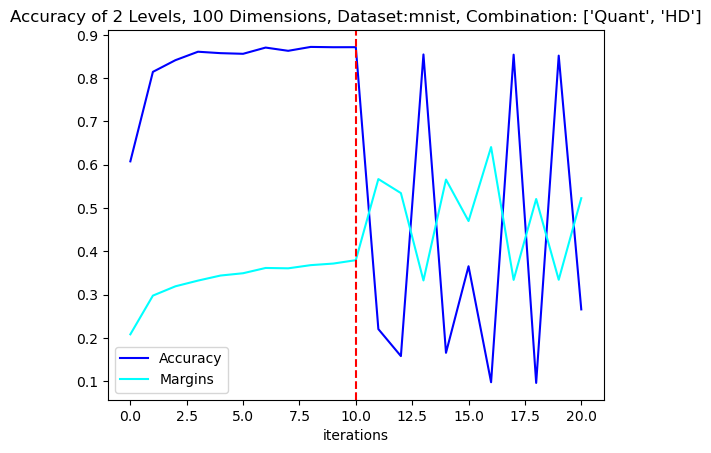

Final Acc: 0.26569998264312744  Final Margin: 0.5226609110832214


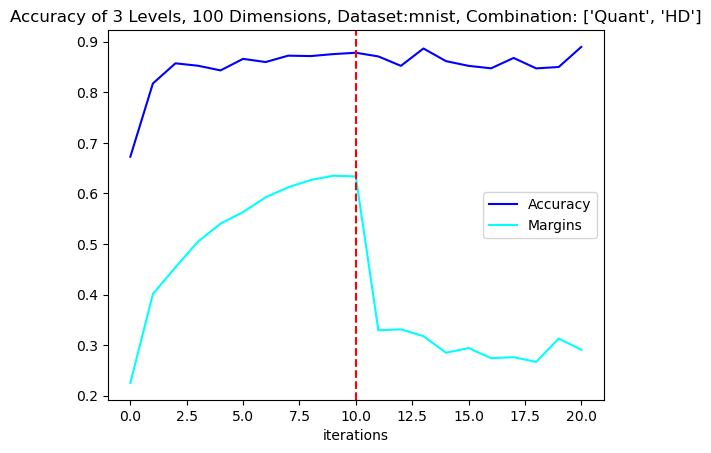

Final Acc: 0.8895999789237976  Final Margin: 0.2910843789577484


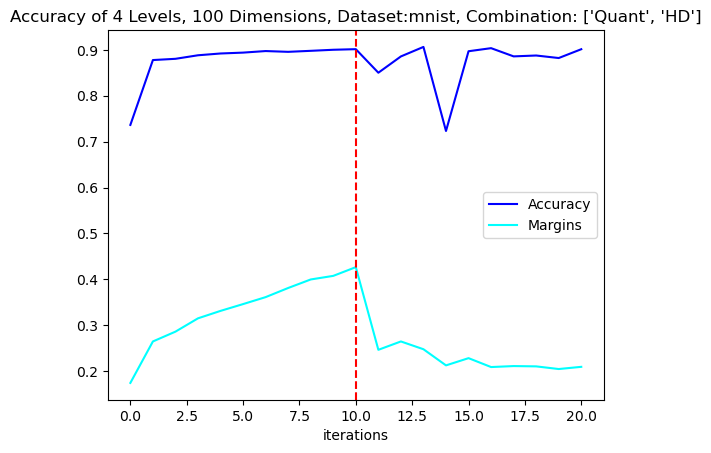

Final Acc: 0.9013999700546265  Final Margin: 0.20957183837890625


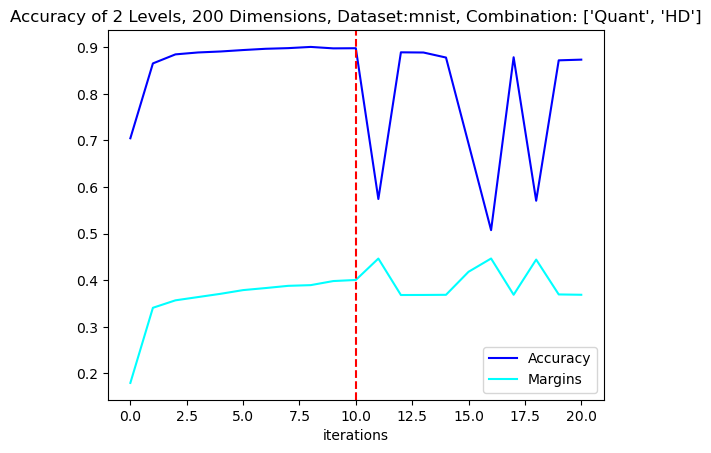

Final Acc: 0.8736000061035156  Final Margin: 0.3687780201435089


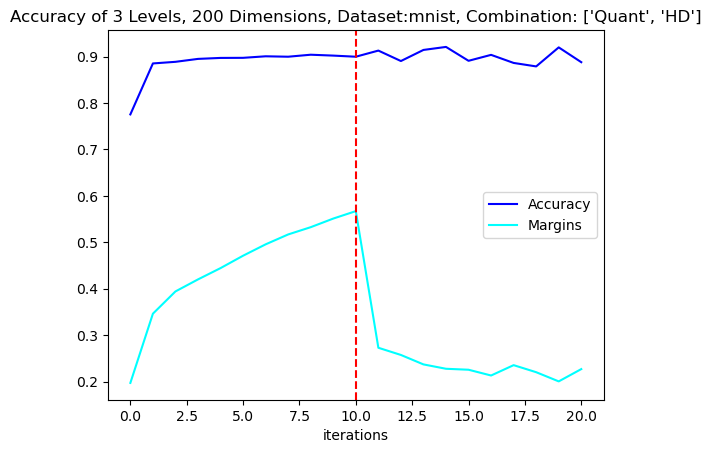

Final Acc: 0.8880999684333801  Final Margin: 0.22684906423091888


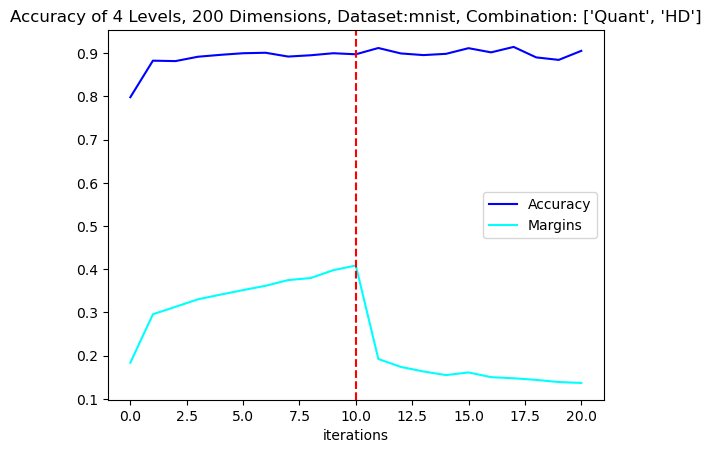

Final Acc: 0.9052000045776367  Final Margin: 0.13704530894756317


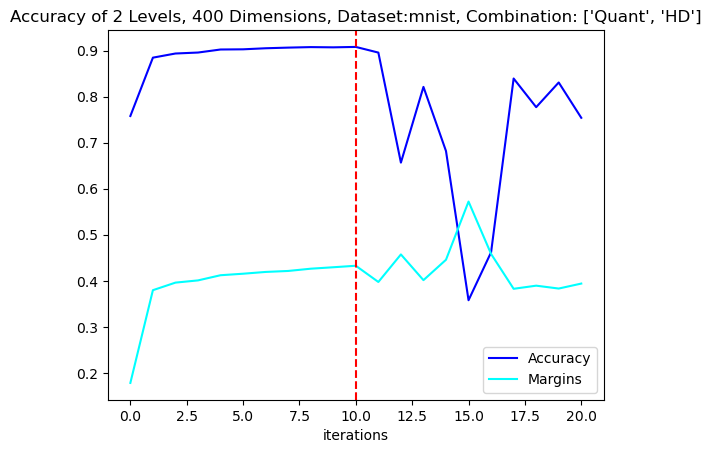

Final Acc: 0.7540000081062317  Final Margin: 0.39406347274780273


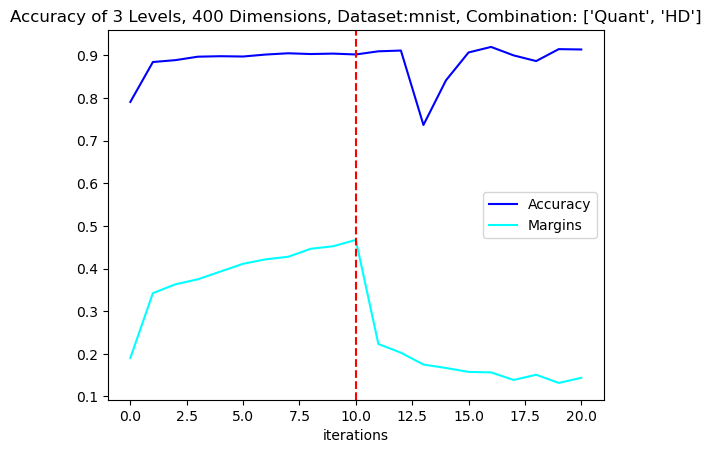

Final Acc: 0.9140999913215637  Final Margin: 0.14378127455711365


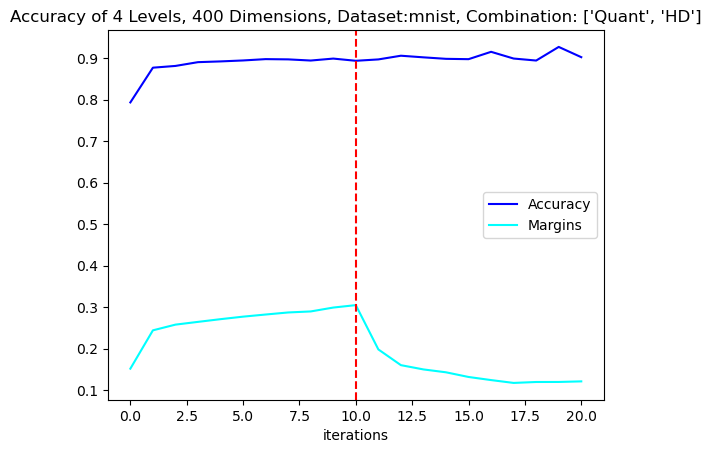

Final Acc: 0.9019999504089355  Final Margin: 0.12098522484302521


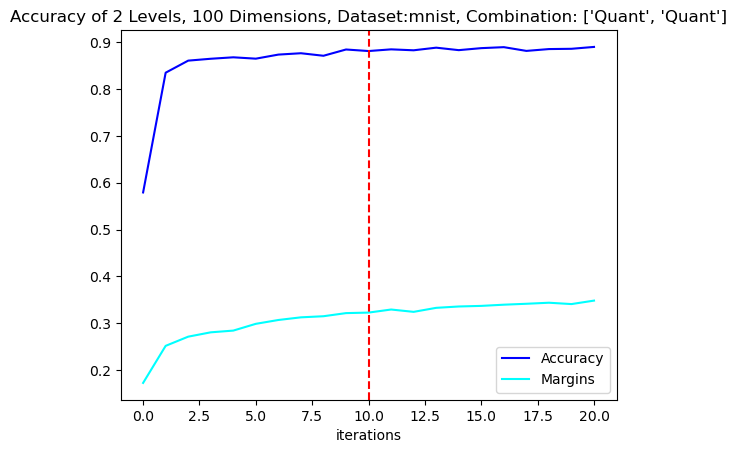

Final Acc: 0.8902999758720398  Final Margin: 0.3479902148246765


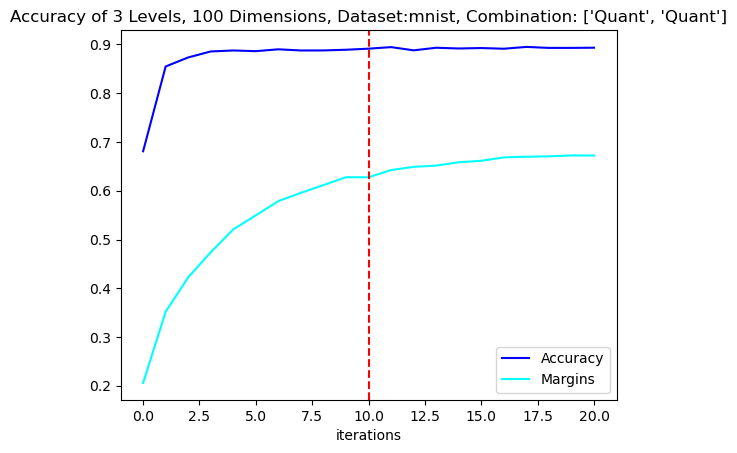

Final Acc: 0.8933999538421631  Final Margin: 0.6721855998039246


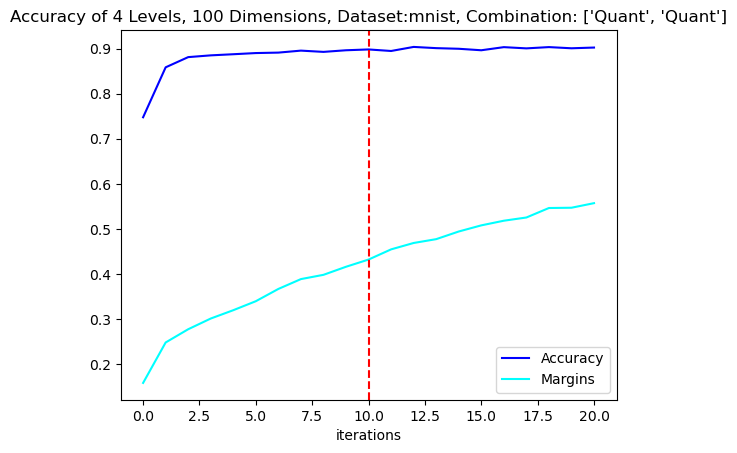

Final Acc: 0.9020999670028687  Final Margin: 0.5572550892829895


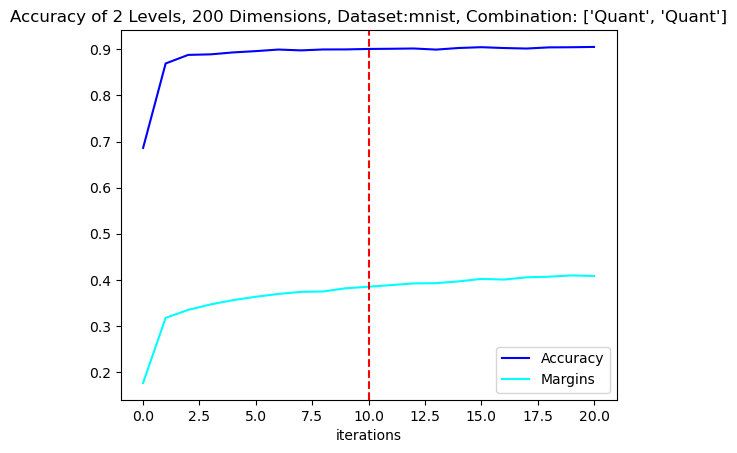

Final Acc: 0.9052000045776367  Final Margin: 0.40831366181373596


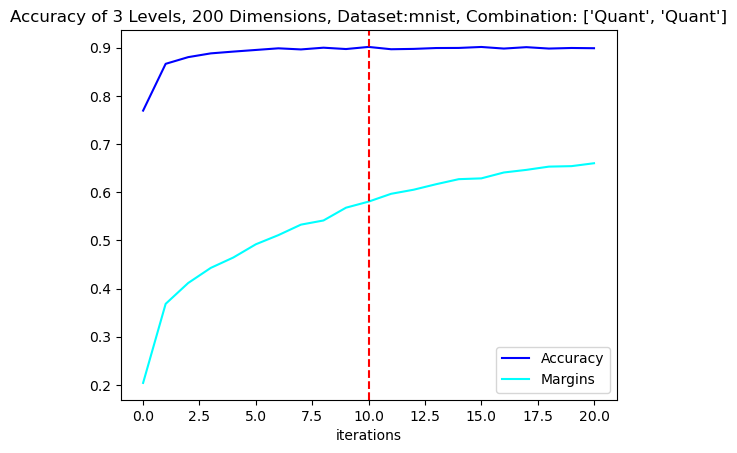

Final Acc: 0.8988999724388123  Final Margin: 0.6601477861404419


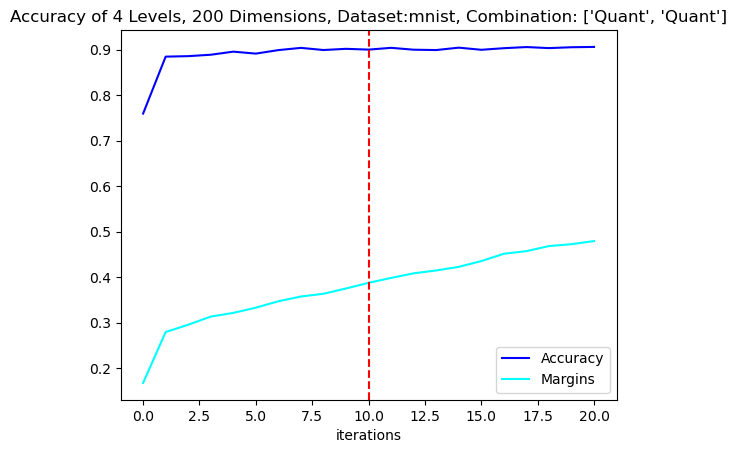

Final Acc: 0.9061999917030334  Final Margin: 0.47913190722465515


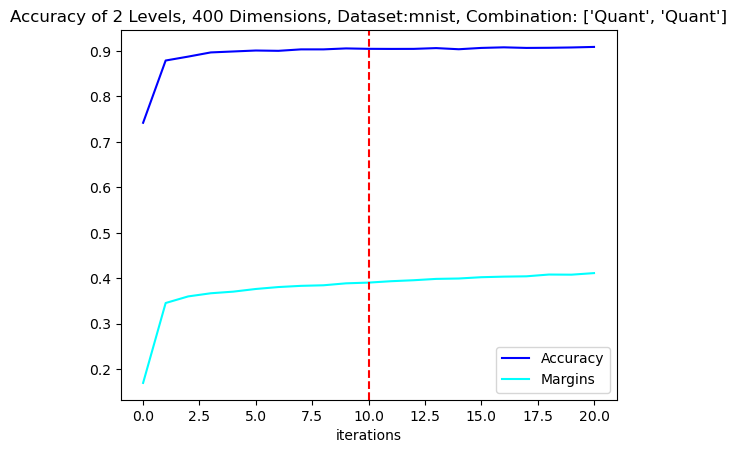

Final Acc: 0.9089999794960022  Final Margin: 0.4113996624946594


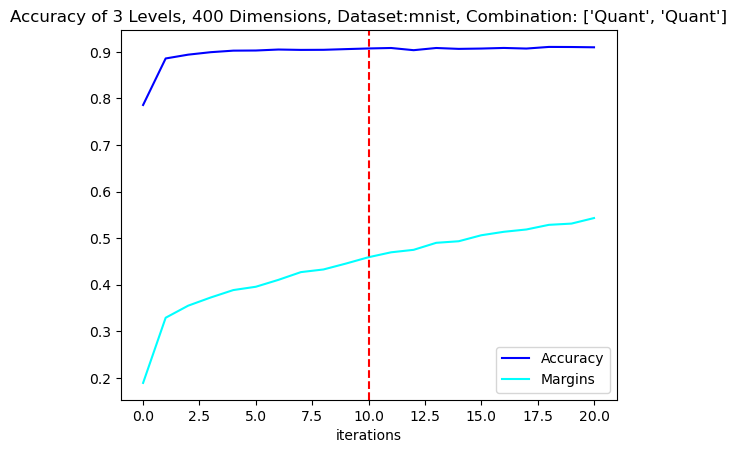

Final Acc: 0.9097999930381775  Final Margin: 0.5430886745452881


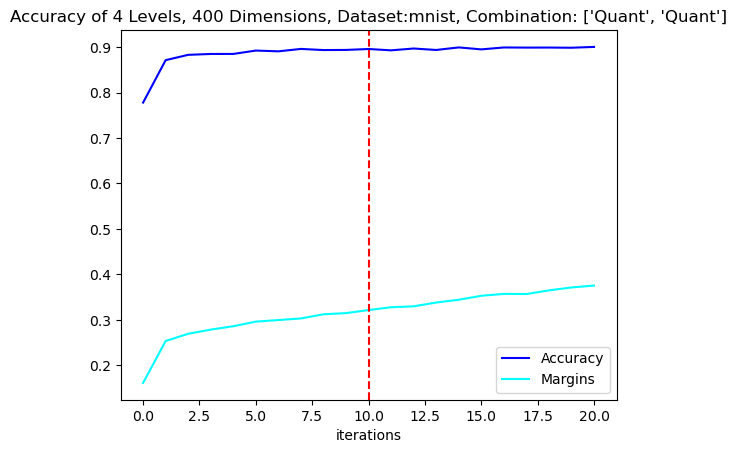

Final Acc: 0.9003999829292297  Final Margin: 0.3754679262638092


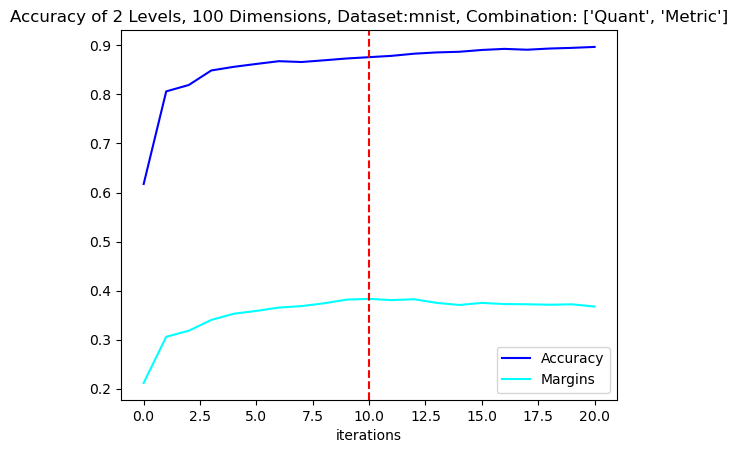

Final Acc: 0.8969999551773071  Final Margin: 0.3673160672187805


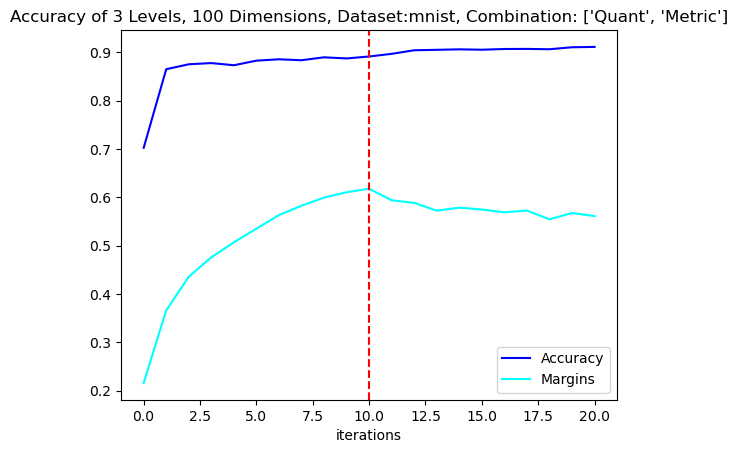

Final Acc: 0.9109999537467957  Final Margin: 0.5610761642456055


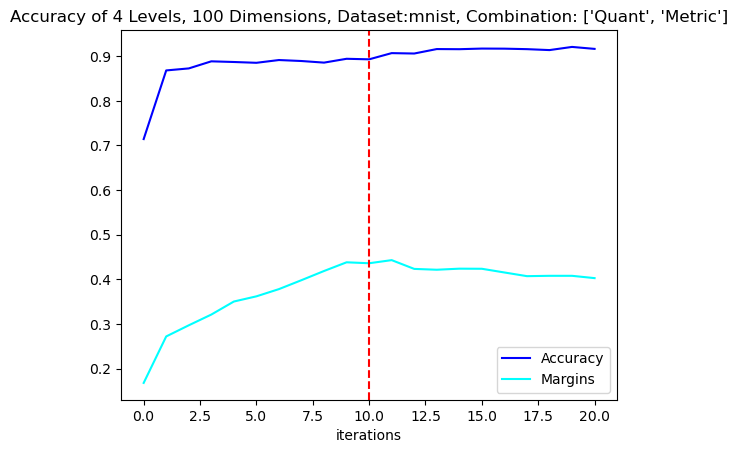

Final Acc: 0.9165999889373779  Final Margin: 0.402639776468277


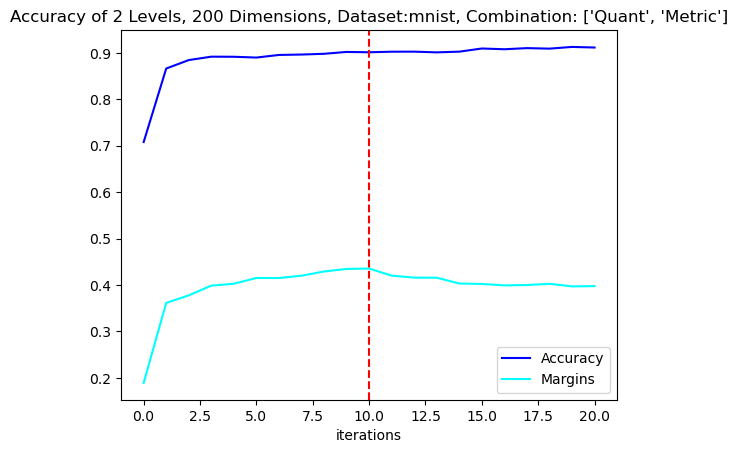

Final Acc: 0.9114999771118164  Final Margin: 0.3977111577987671


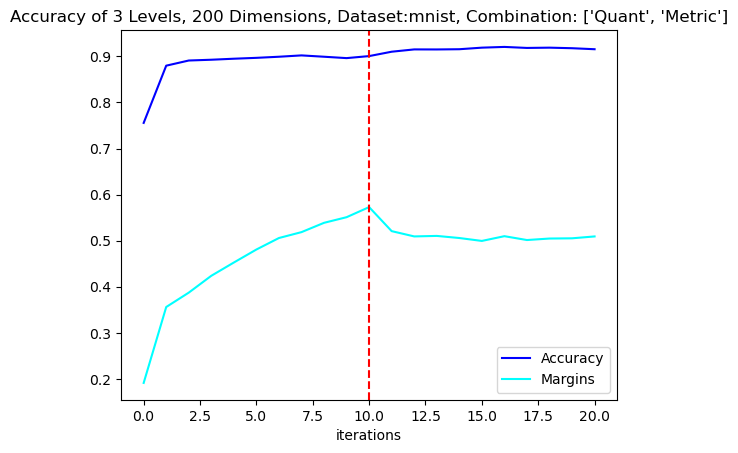

Final Acc: 0.9154999852180481  Final Margin: 0.5091747641563416


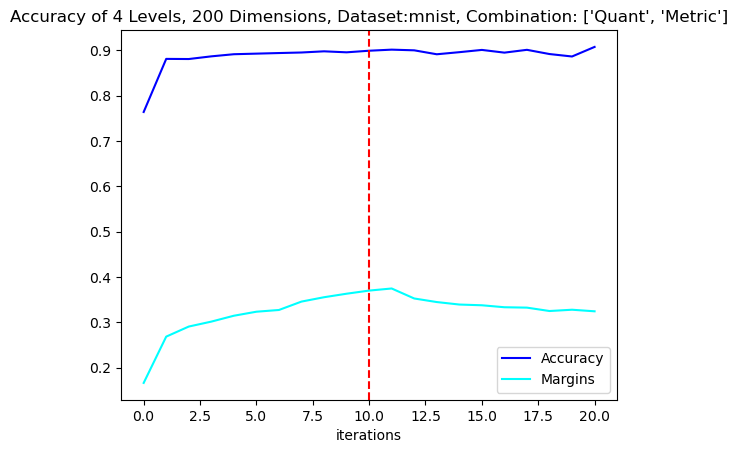

Final Acc: 0.9073999524116516  Final Margin: 0.324354887008667


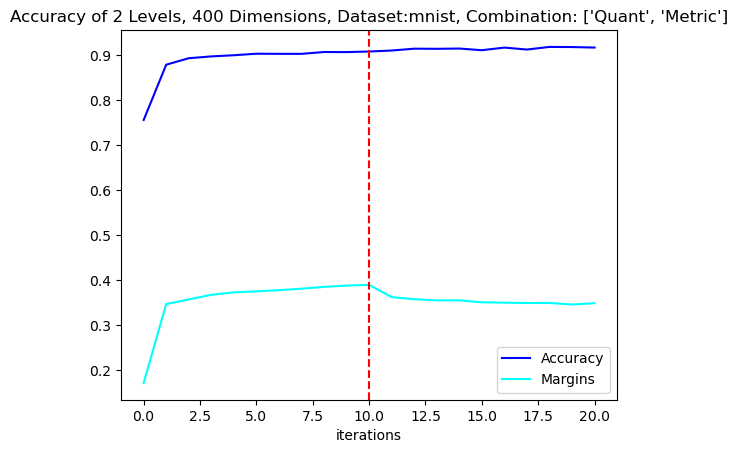

Final Acc: 0.9167999625205994  Final Margin: 0.34867408871650696


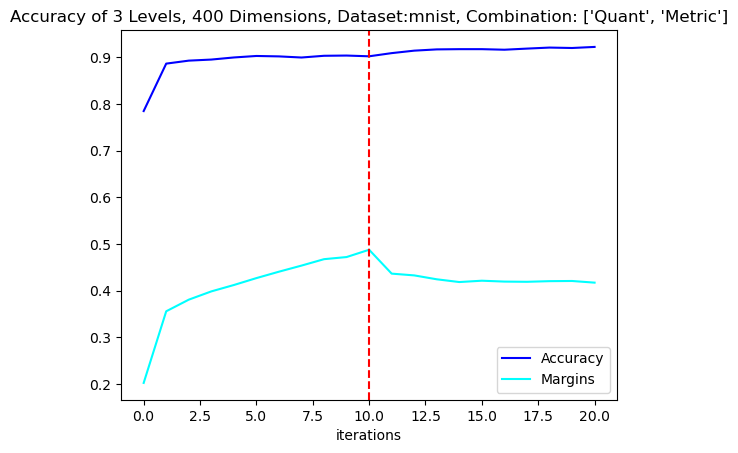

Final Acc: 0.92249995470047  Final Margin: 0.41716551780700684


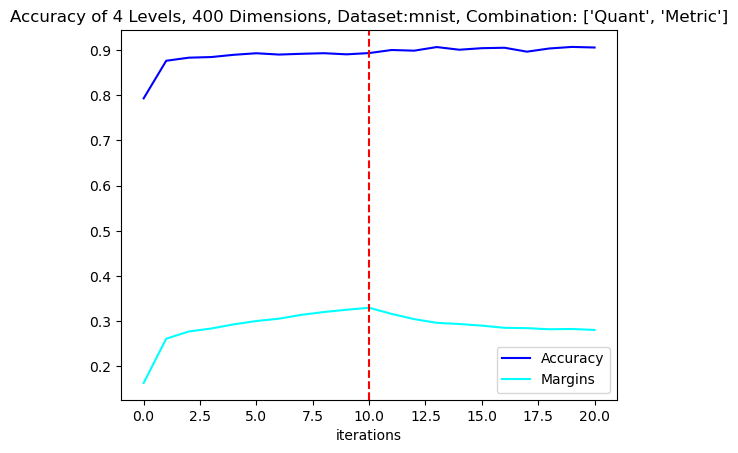

Final Acc: 0.9054999947547913  Final Margin: 0.2808266878128052


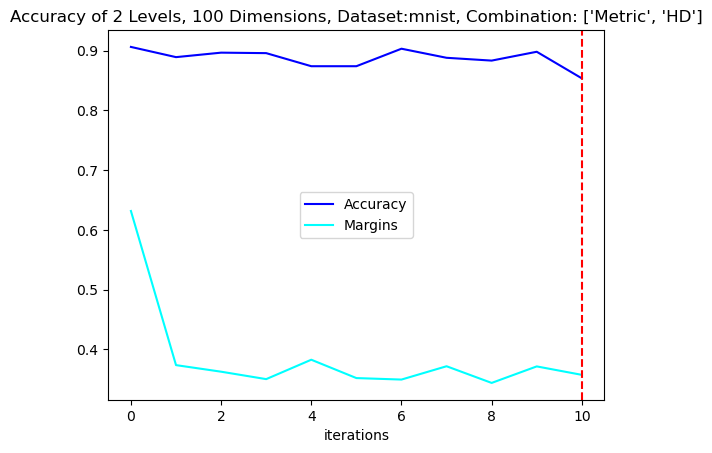

Final Acc: 0.8537999987602234  Final Margin: 0.35731425881385803


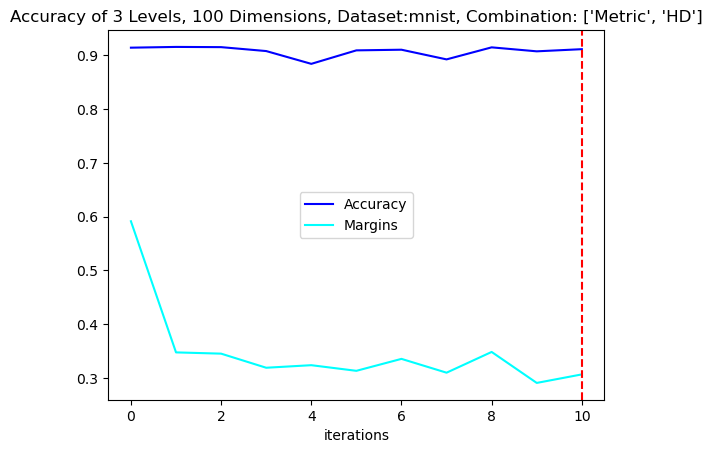

Final Acc: 0.9116999506950378  Final Margin: 0.30647012591362


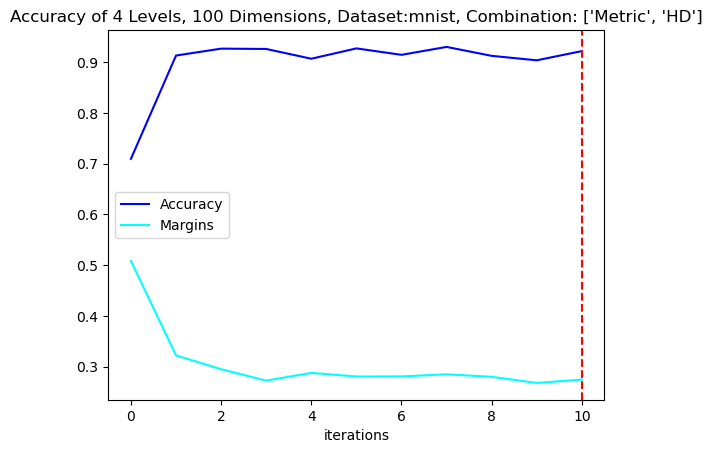

Final Acc: 0.9218999743461609  Final Margin: 0.2744663953781128


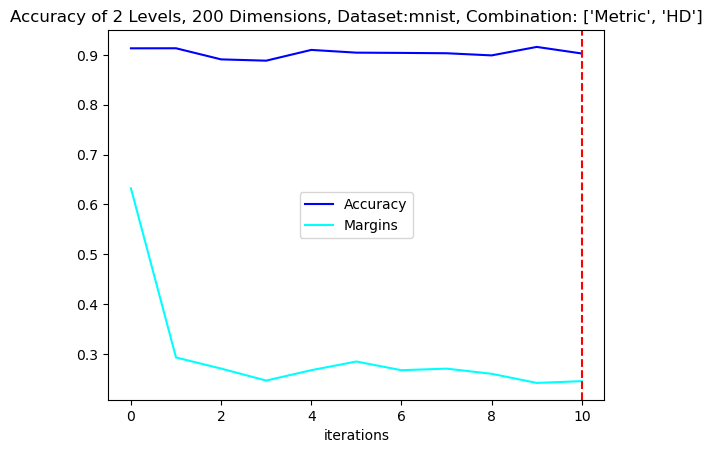

Final Acc: 0.9027999639511108  Final Margin: 0.24517089128494263


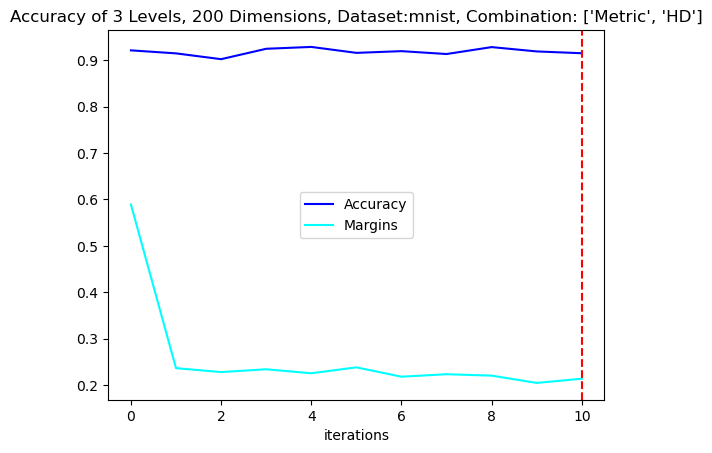

Final Acc: 0.9147999882698059  Final Margin: 0.21362967789173126


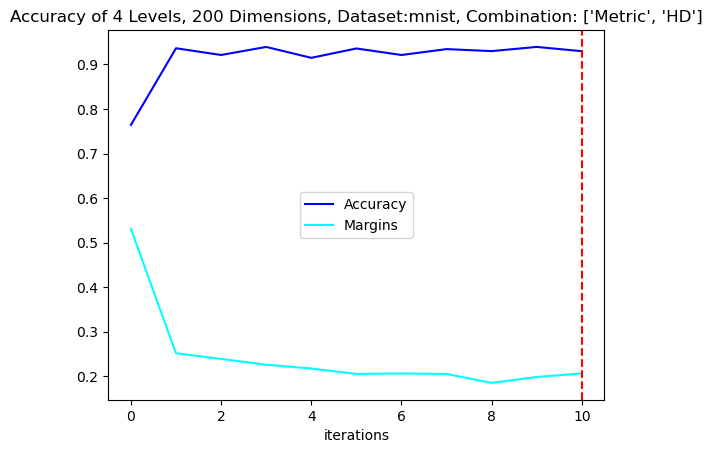

Final Acc: 0.9296000003814697  Final Margin: 0.2063838392496109


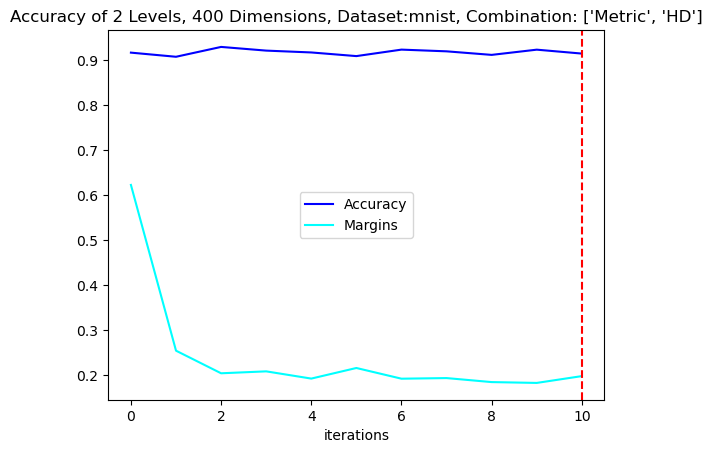

Final Acc: 0.914199948310852  Final Margin: 0.19707389175891876


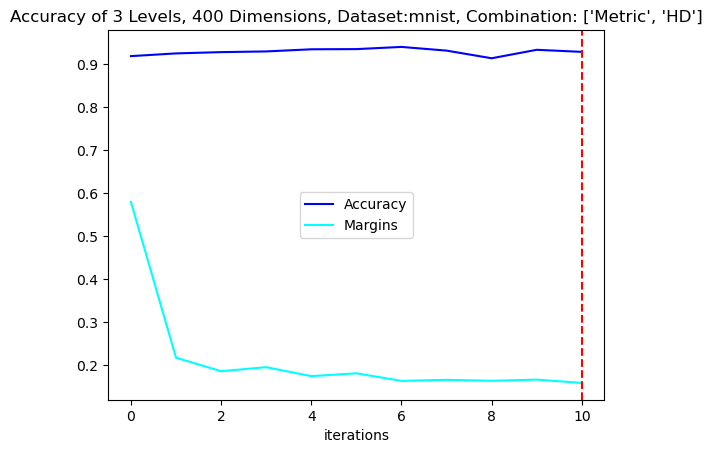

Final Acc: 0.9289000034332275  Final Margin: 0.15834559500217438


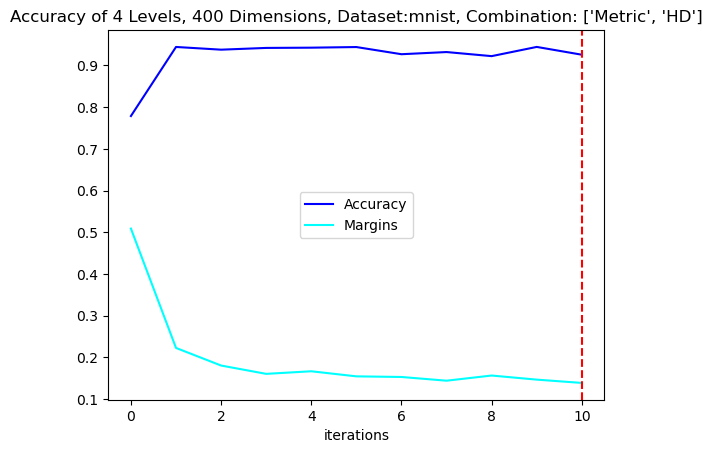

Final Acc: 0.9257999658584595  Final Margin: 0.1383282095193863


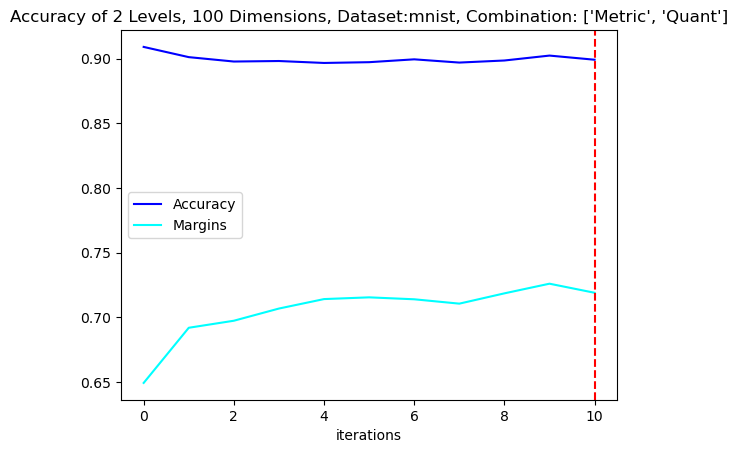

Final Acc: 0.8991999626159668  Final Margin: 0.7189598679542542


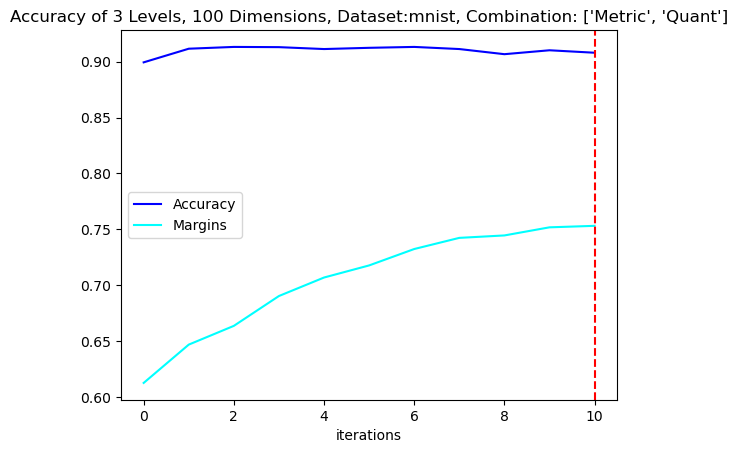

Final Acc: 0.9079999923706055  Final Margin: 0.7531178593635559


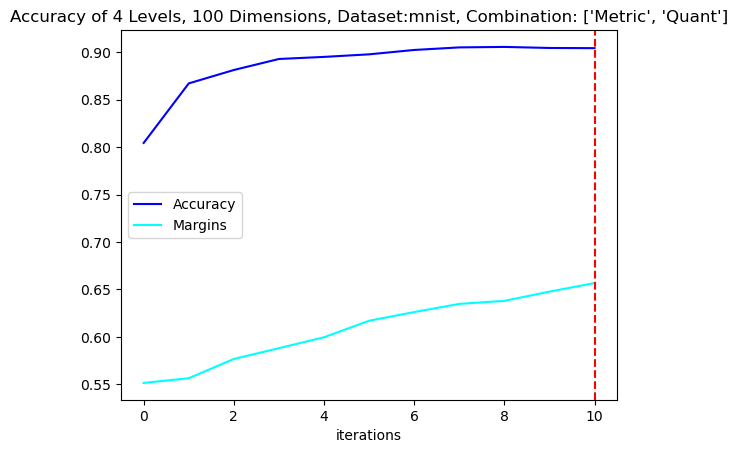

Final Acc: 0.9041000008583069  Final Margin: 0.656784176826477


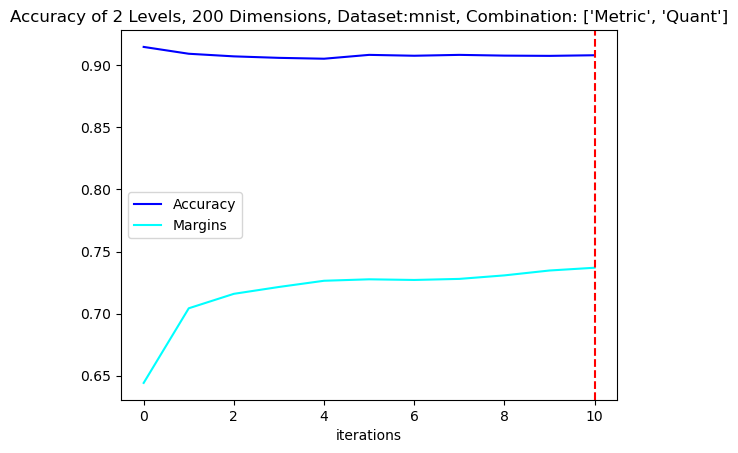

Final Acc: 0.9079999923706055  Final Margin: 0.7369463443756104


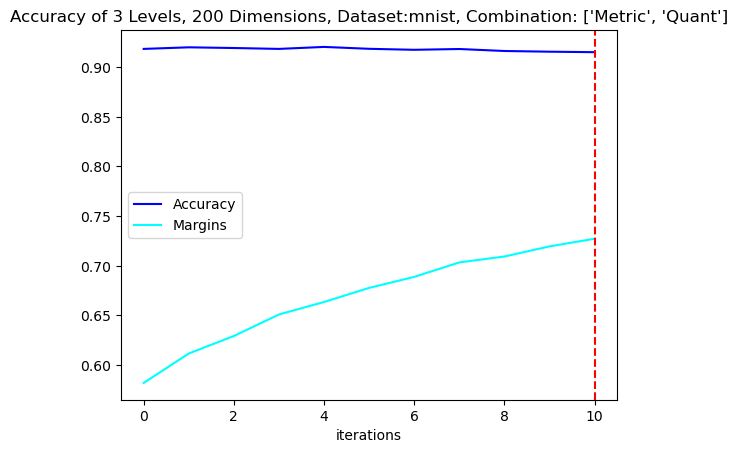

Final Acc: 0.9150999784469604  Final Margin: 0.7272273302078247


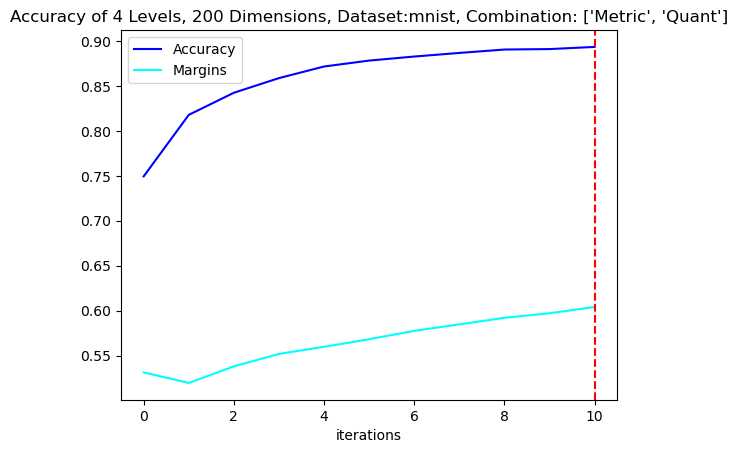

Final Acc: 0.8933999538421631  Final Margin: 0.604104220867157


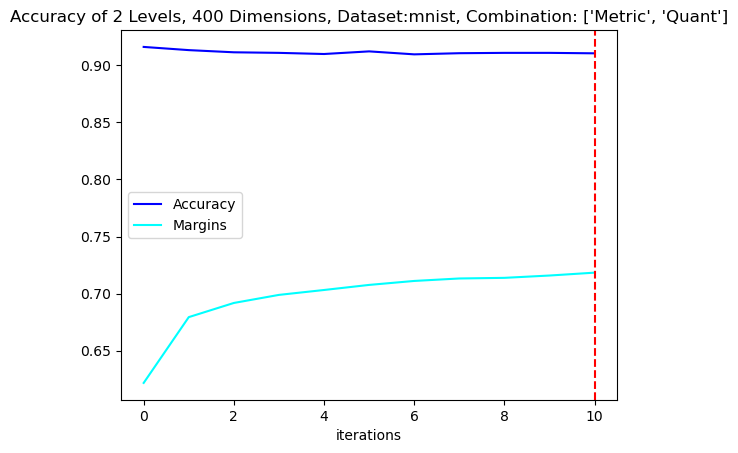

Final Acc: 0.9102999567985535  Final Margin: 0.7183756232261658


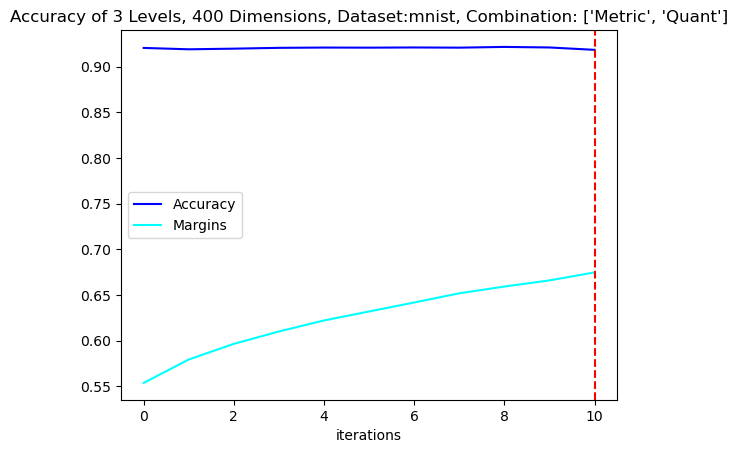

Final Acc: 0.9185000061988831  Final Margin: 0.6748825311660767


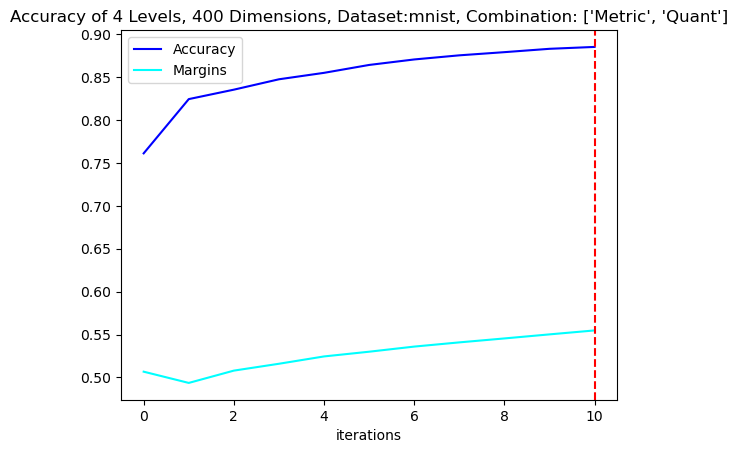

Final Acc: 0.8851000070571899  Final Margin: 0.5548033714294434


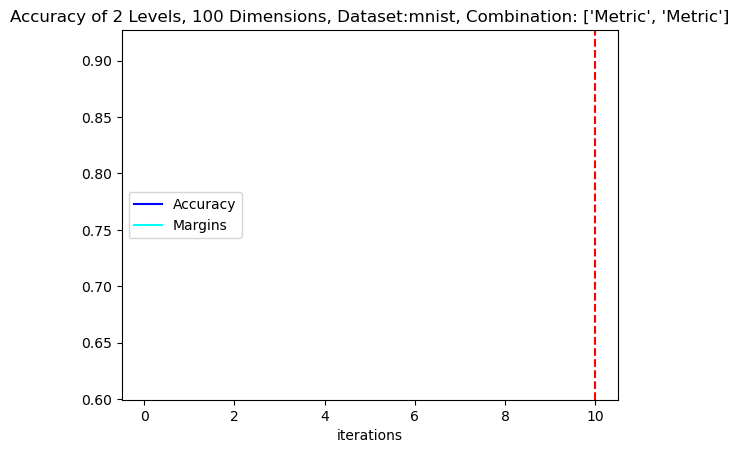

Final Acc: 0.9120999574661255  Final Margin: 0.6143475770950317


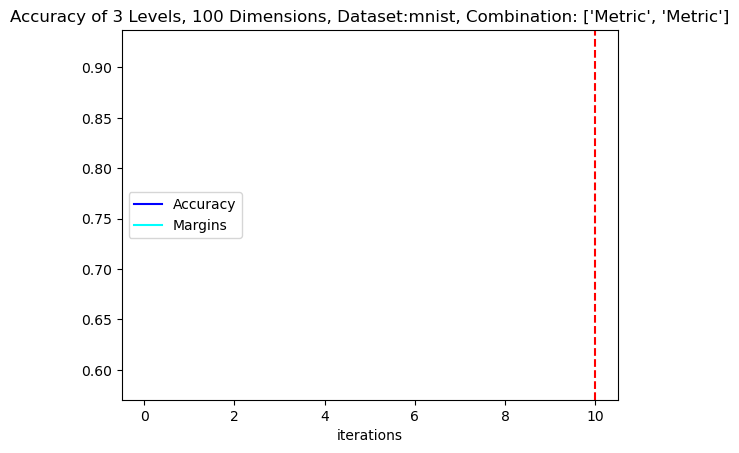

Final Acc: 0.9202999472618103  Final Margin: 0.5870473384857178


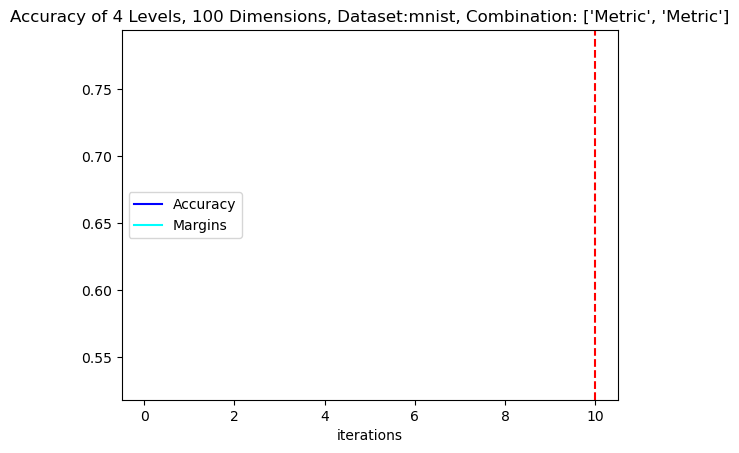

Final Acc: 0.781499981880188  Final Margin: 0.5309380888938904


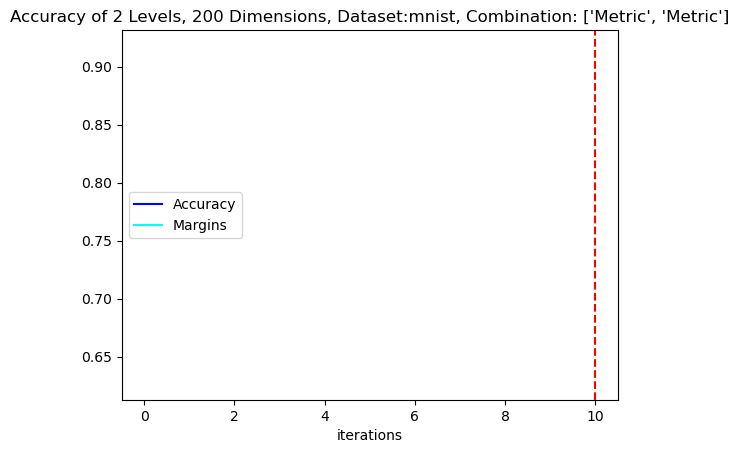

Final Acc: 0.9169999957084656  Final Margin: 0.6274255514144897


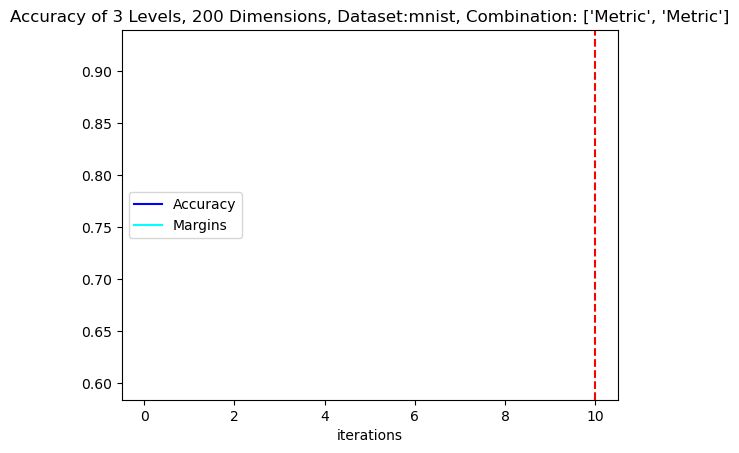

Final Acc: 0.9232999682426453  Final Margin: 0.5999053716659546


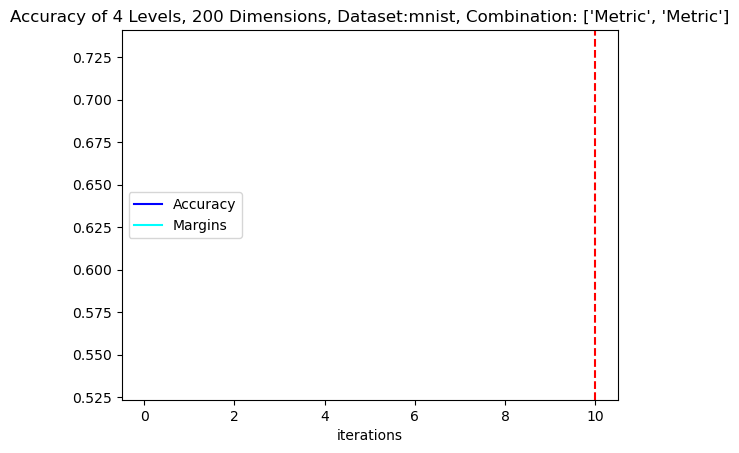

Final Acc: 0.7310999631881714  Final Margin: 0.5333271622657776


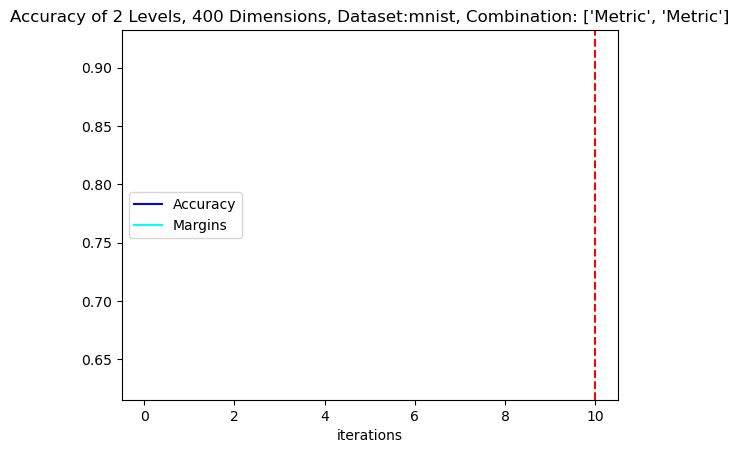

Final Acc: 0.9177999496459961  Final Margin: 0.6297629475593567


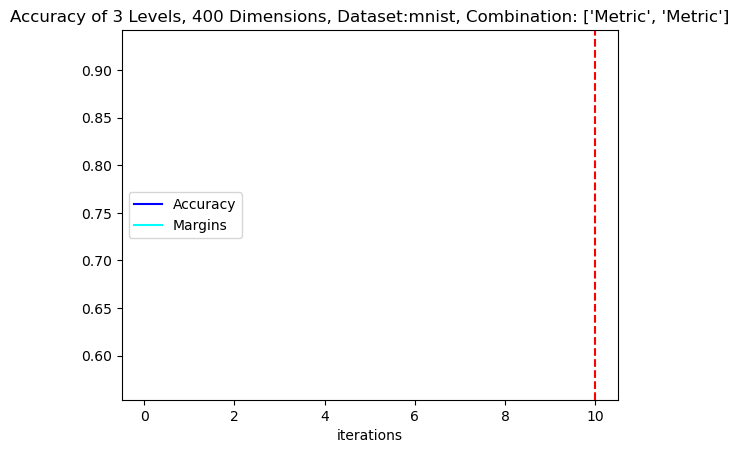

Final Acc: 0.9241999983787537  Final Margin: 0.5713527202606201


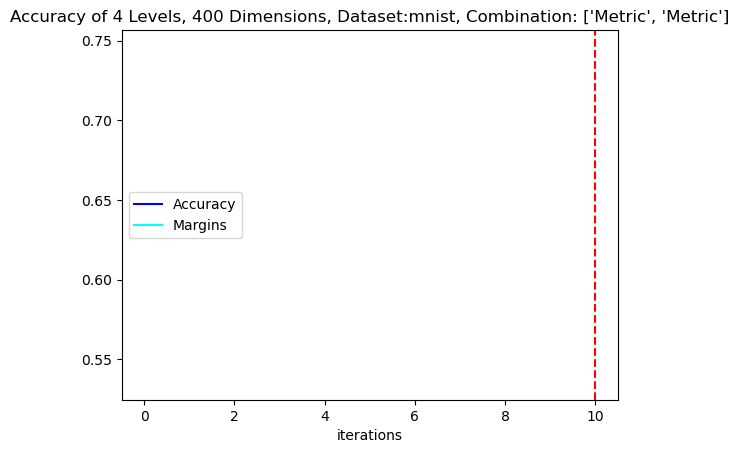

Final Acc: 0.7461000084877014  Final Margin: 0.5352319478988647


In [2]:
training_methods = [ "HD", "Quant", "Metric"]
datasets = ["mnist"]
levels = [2, 3,4]
dimensions = [100,200,400]
# datasets = ["pamap2"]

results = {}
for dataset in datasets:
    results[dataset] = {}
    for first_train in training_methods:
        for second_train in training_methods:
                for dimension in dimensions:
                    for level in levels:
                        combination = [first_train, second_train]
                        accuracies, margins = test_combination(dataset, dimension, level, combinations=combination)
                        final_acc = accuracies[len(accuracies)-1]
                        final_marg = margins[len(margins) - 1]
                        print("Final Acc:", final_acc, " Final Margin:", final_marg)
                        results[dataset][(first_train, second_train, level, dimension)] = (final_acc, final_marg)

In [3]:
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_excel("output.xlsx", sheet_name="Sheet1")

                                                       mnist
HD    HD    2 100  (0.6527999639511108, 0.23278534412384033)
              200  (0.7468000054359436, 0.19809889793395996)
              400  (0.8387999534606934, 0.16085022687911987)
            3 100  (0.7590000033378601, 0.26300927996635437)
              200  (0.8114999532699585, 0.20127476751804352)
...                                                      ...
Quant Quant 3 200   (0.8988999724388123, 0.6601477861404419)
              400   (0.9097999930381775, 0.5430886745452881)
            4 100   (0.9020999670028687, 0.5572550892829895)
              200  (0.9061999917030334, 0.47913190722465515)
              400   (0.9003999829292297, 0.3754679262638092)

[81 rows x 1 columns]
